#### For this problem set I worked with Eugene Leypunskiy

We've documented each section with what we did througout the notebook and our overall comment is at the end of the notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import string
from collections import Counter, OrderedDict
import nltk
from nltk.corpus import stopwords
import re
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.clustering import DistributedLDAModel

### Part 2(a): Fit light curves using Nadaraya-Watson Kernel Estimator


In [2]:
spark = SparkSession.builder.master('local[*]')\
                            .appName('light_curves')\
                            .config("spark.driver.maxResultSize", "20g")\
                            .config("spark.driver.memory", "20g")\
                            .config("spark.executor.memory", "20g")\
                            .getOrCreate()

lc = spark.read.json('/project/cmsc25025/light_curve/lightcurves-sample.json')

In [16]:
# Retrieving data
allLightCurves = lc.rdd.map(lambda x: (x['label'], x['name'], x['time'], x['flux'])).collect()

In [17]:
# Write a function to throw out data with NaN values

def parse_flux_time(flux,time):
    new_flux = []
    new_time = []
    for i, fluxEntry in enumerate(flux):
        if str(fluxEntry) == 'nan':
            continue
        else:
            new_flux.append(flux[i])
            new_time.append(time[i])
    return new_flux, new_time

# Function for calculating Risk
# Lii is the maximum value of the normalized weight vector
# Using the shortcut formula for calculating risk

def calc_risk(flux,yhat,w):
    riskSum = 0
    riskNum = 0
    lii = np.max( w / np.linalg.norm(w))
    for i in range(len(flux)):
        top = flux[i] - yhat[i]
        bot = 1 - lii
        riskSum = riskSum + (top / bot )**2
        riskNum = riskNum + 1
    return riskSum/riskNum

# Epanechnikov kernel

def kernel_epa(u):
    w = (abs(u) <= 1) * (1 - u*u)
    return w[w>0]

LC1, Bandwidth with lowest Risk: h= 0.061 Risk= 13351.6837784
LC2, Bandwidth with lowest Risk: h= 0.469 Risk= 171724.258217
LC3, Bandwidth with lowest Risk: h= 0.101 Risk= 417.792469119
LC4, Bandwidth with lowest Risk: h= 0.082 Risk= 791.118879565
LC5, Bandwidth with lowest Risk: h= 0.04 Risk= 561.259355554
LC6, Bandwidth with lowest Risk: h= 0.061 Risk= 4300.97863441
LC7, Bandwidth with lowest Risk: h= 0.082 Risk= 19178.8423108
LC8, Bandwidth with lowest Risk: h= 0.061 Risk= 63.4697414716
LC9, Bandwidth with lowest Risk: h= 0.122 Risk= 132.799546431
LC10, Bandwidth with lowest Risk: h= 0.081 Risk= 78728.4830913
LC11, Bandwidth with lowest Risk: h= 0.082 Risk= 652.867520843
LC12, Bandwidth with lowest Risk: h= 0.122 Risk= 332.46691938


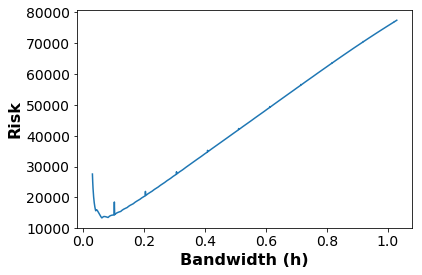

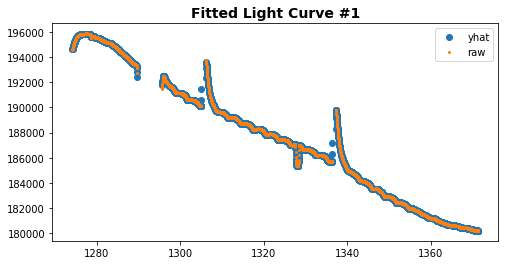

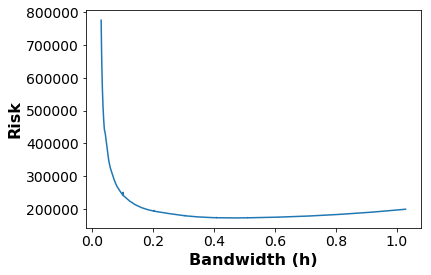

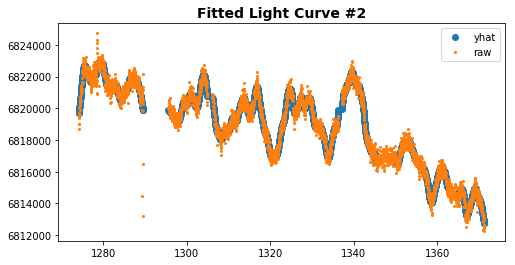

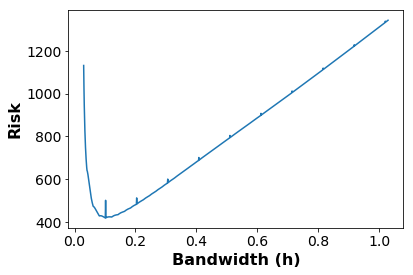

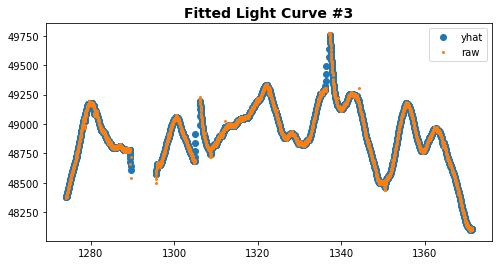

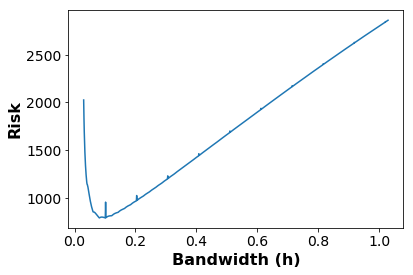

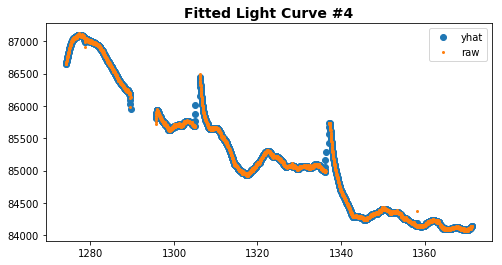

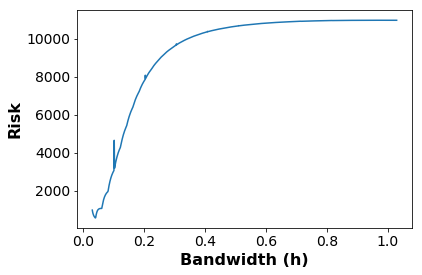

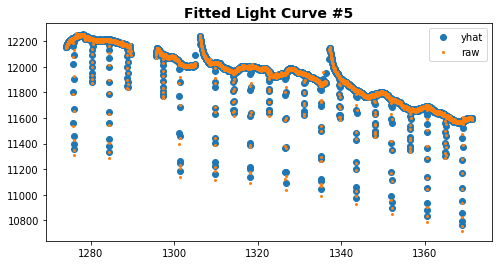

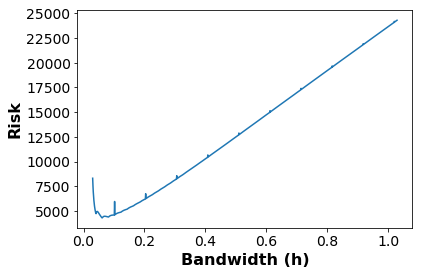

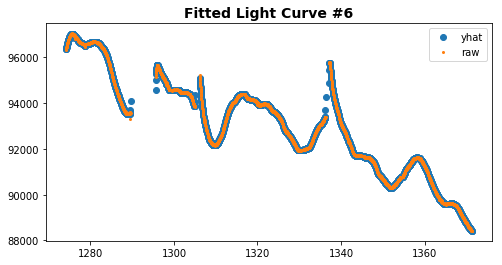

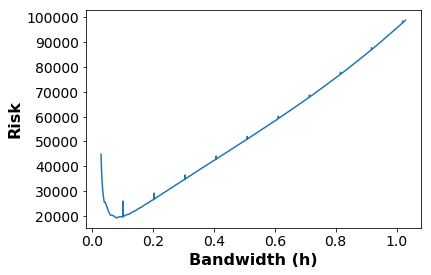

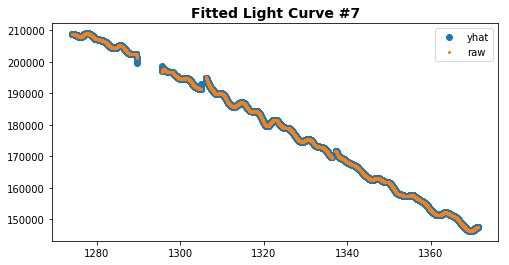

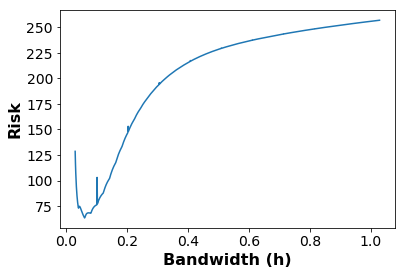

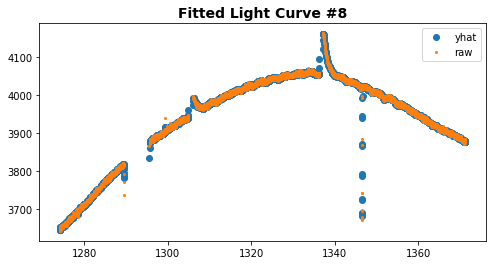

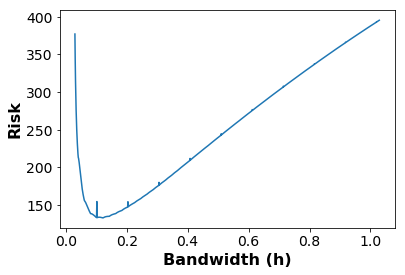

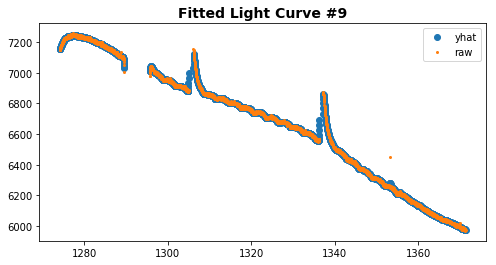

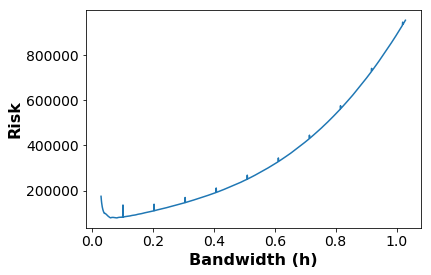

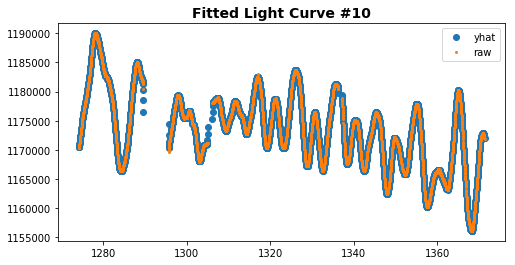

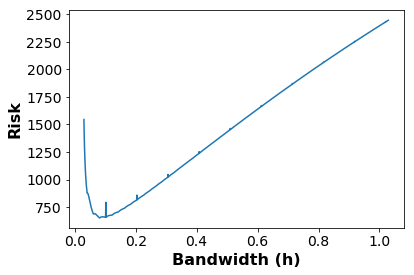

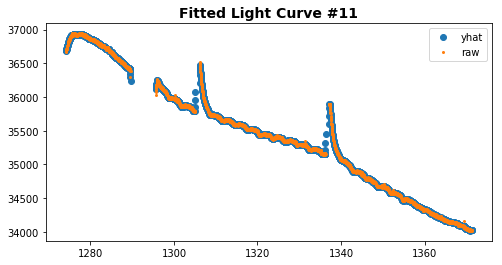

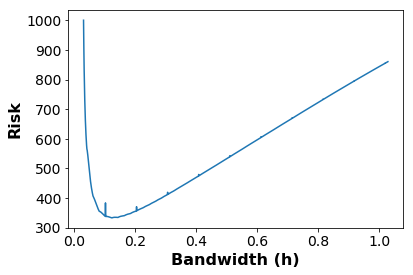

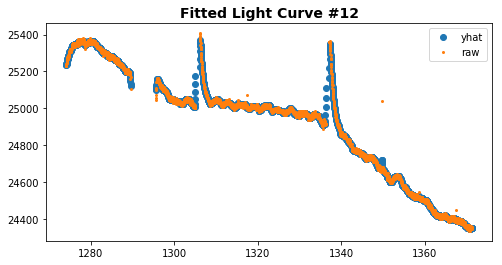

In [18]:
# Fit the residuals and plot them
all_residuals = []
for i in range(12):
    # Parse data to throw away NaN values
    flux,time = parse_flux_time(allLightCurves[i][3], allLightCurves[i][2])
    gap = 0.0204
    N = 4324 # N is smaller because we threw away data with NaN values
    sz = (N-1)/2
    u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)

    hs = [h*0.001+0.03 for h in range(1000)] # Just making a list of bandwidths
    risks = [] 
    lowestRisk = 1000000000 # Make it a very large number initially

    for h in hs:
        w = kernel_epa(u/h)
        const = np.convolve(w, np.ones(len(flux), dtype=np.float64), 'same')
        yhat = np.convolve(w, flux, 'same') / const
        risk = calc_risk(flux,yhat,w)
        if risk < lowestRisk: # Finding bandwidth with lowest risk
            lowestRisk = risk
            lowestH = h
        risks.append(risk)

    print "LC%s, Bandwidth with lowest Risk: h=" % (i + 1), lowestH, "Risk=",lowestRisk
    # Here we're refitting with the optimal bandwidth to plot and calculate residuals
    h = lowestH
    w = kernel_epa(u/h)
    const = np.convolve(w, np.ones(len(flux), dtype=np.float64), 'same')
    yhat = np.convolve(w, flux, 'same') / const
    residuals = flux - yhat
    all_residuals.append(residuals)
    plt.figure()
    plt.plot(hs,risks)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Bandwidth (h)', fontsize=16, fontweight='bold')
    plt.ylabel('Risk', fontsize=16, fontweight='bold')
    plt.figure(figsize=(8,4))
    plt.plot(time,yhat,'o', label='yhat')
    plt.plot(time,flux,'o',ms=2, label='raw')
    plt.legend(loc=0)
    plt.title('Fitted Light Curve #%d' % ( i+ 1), fontsize=14,fontweight='bold')



## Part 2(b): Compute Residuals

Residuals were computed in the above cell with the bandwidth (h) value that minimizes the risk. I'll plot the residuals for all lightcurves in the following cell.

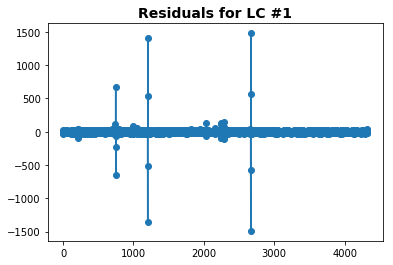

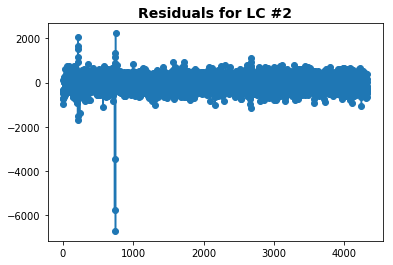

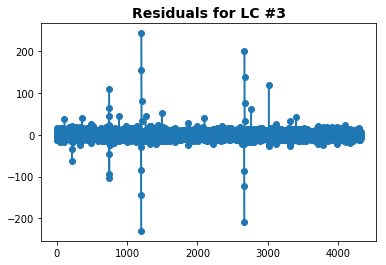

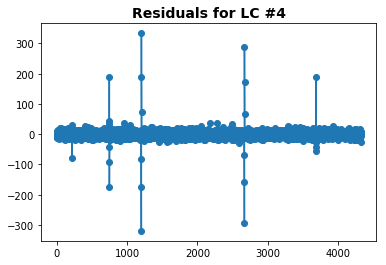

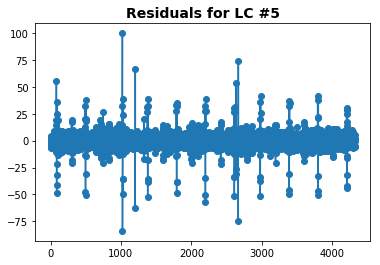

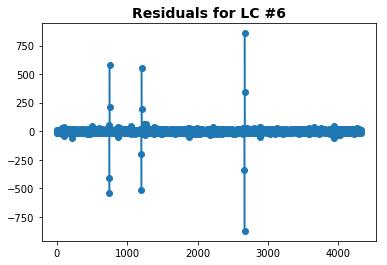

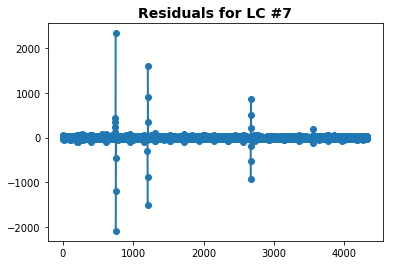

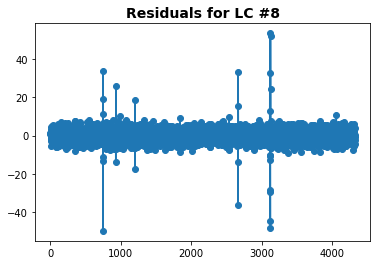

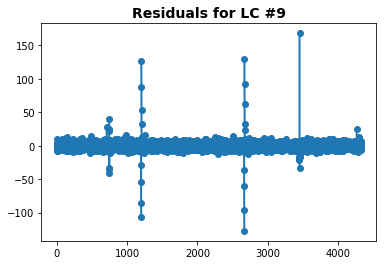

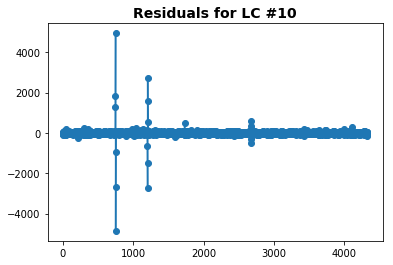

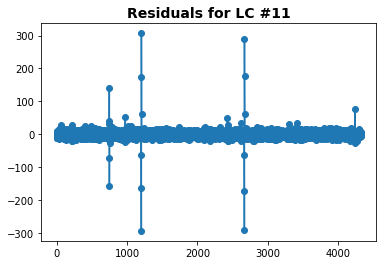

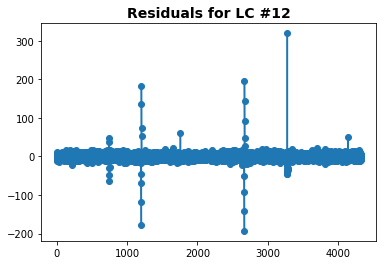

In [19]:
lightCurveNum = 0
for i in all_residuals:
    plt.figure()
    plt.title('Residuals for LC #%d' % (lightCurveNum + 1), fontsize=14,fontweight='bold')
    plt.plot(i,'o-')
    lightCurveNum = lightCurveNum + 1

## Part 2(c): Standardize the residuals

Here we're standardizing by subtracting the residuals by its mean and dividing by variance, which is estimated using median absolute deviation (MAD).

$$ \sigma = 1.4826 \dot MAD(X) $$
$$ MAD(X) = median(|X - median(X)|) $$

In [22]:
standardized_residuals = []
for i in all_residuals:
    i = i - np.mean(i)
    i = i / (1.4826 * np.median(np.abs(i - np.median(i))))
    standardized_residuals.append(i)
            
    
    

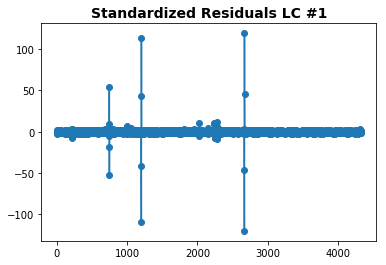

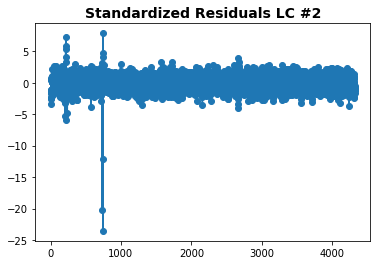

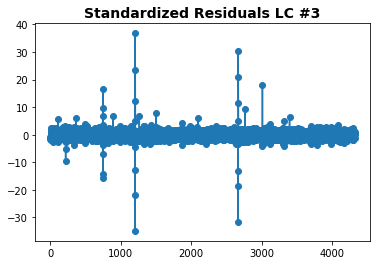

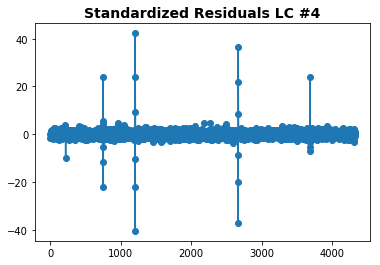

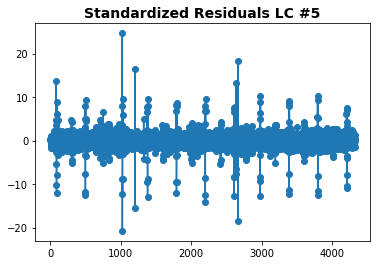

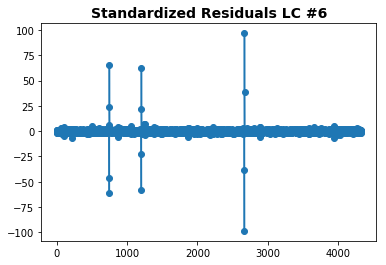

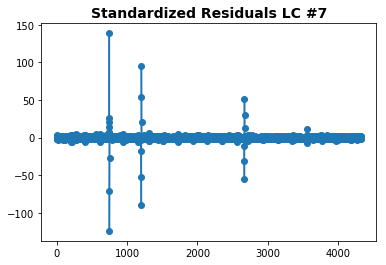

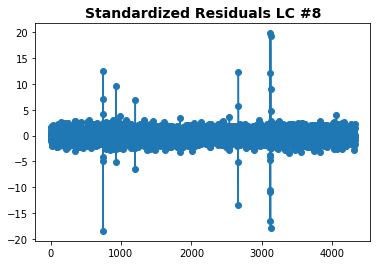

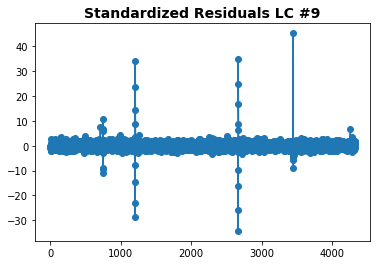

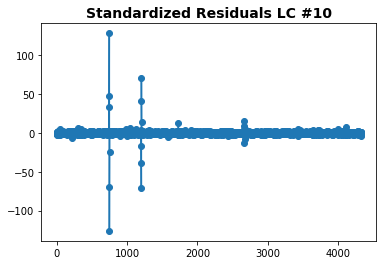

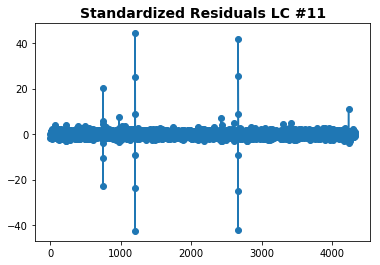

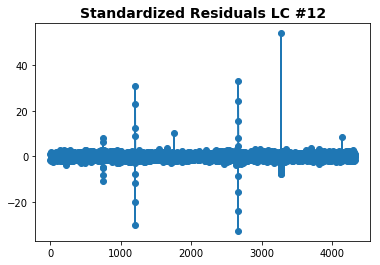

In [23]:
lightCurveNum = 0
for i in standardized_residuals:
    plt.figure()
    plt.title('Standardized Residuals LC #%d' % (lightCurveNum + 1), fontsize=14,fontweight='bold')
    plt.plot(i,'o-')
    lightCurveNum = lightCurveNum + 1

## Part 2(d): Thresholding

In [25]:
# Here the threshold is just a number defined as sqrt of 2log(n)
threshold = np.sqrt(2*np.log(4757))
print threshold

4.11518468515


In [27]:
# Defining a function to only keep values of ri that are less than -threshold
def threshold_data(threshold, residuals):
    threshResid = []
    for i in residuals:
        if i >= -threshold:
            i = 0.
            threshResid.append(i)
        else:
            threshResid.append(i)
    return threshResid
            


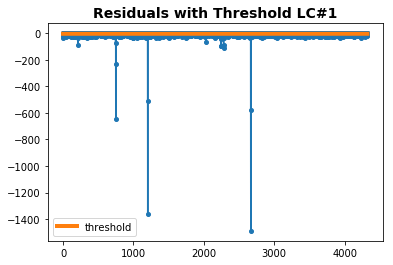

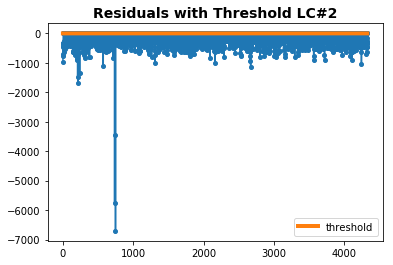

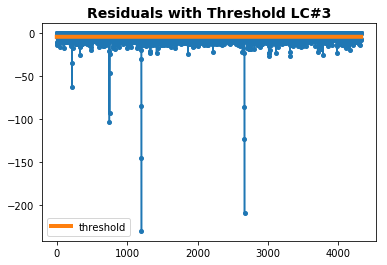

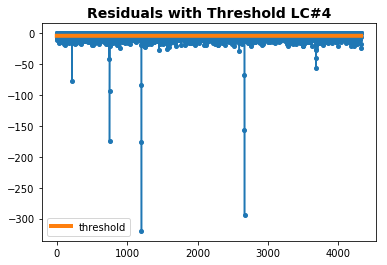

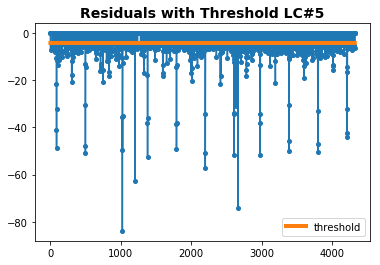

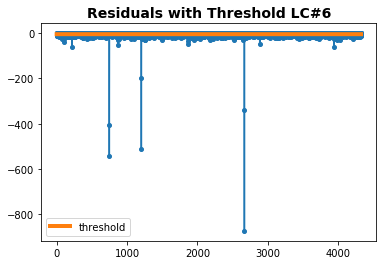

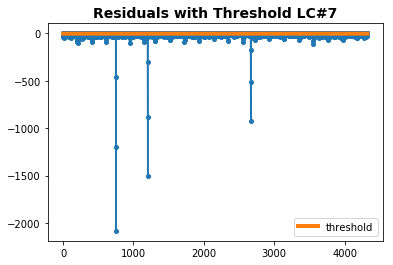

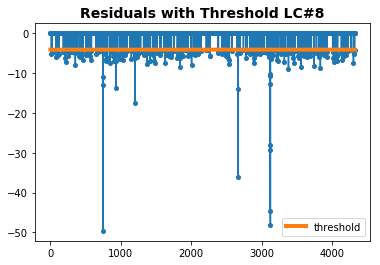

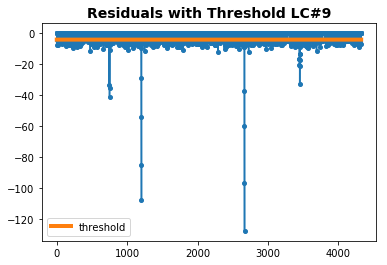

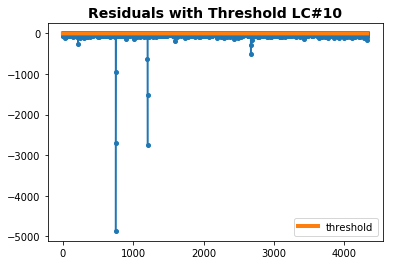

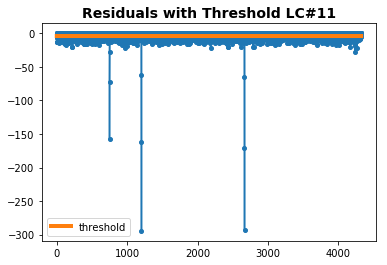

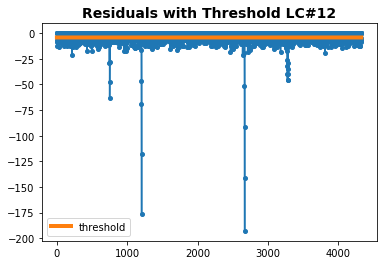

In [30]:
lightCurveNum = 0
for i in all_residuals:
    threshResid = threshold_data(threshold, i)
    plt.figure()
    plt.title('Residuals with Threshold LC#%d' % (lightCurveNum + 1), fontsize=14,fontweight='bold')
    plt.plot(threshResid,'-o', ms=4)
    plt.plot(np.arange(len(threshResid)), [-threshold for i in range(len(threshResid))],lw=4, label='threshold')
    plt.legend(loc=0)
    lightCurveNum = lightCurveNum + 1

## Comment

We're not the experts of looking at planetary systems and lightcurves so our intution is very light. LC #5 seems to be the only lightcurve with gaussian residuals + periodic spikes indicating that there's a planet or eclipsing star. LC #1 through #4 has some spikes but we don't have many spikes so that it's hard to tell if they represent a planet or eclipsing star. However, based on their labels from our initial data, seems like #1-#4 should be confirmed planets, #5-#8 should be eclipsing binary and #9-#12 should be false positive. From the thresholded residuals, it's still hard for us to pickout why one is considered false positive vs another. 